# imports & device setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# "CUDA" means a GPU device -- it makes the training much faster!
DEVICE: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE = }")

DEVICE = device(type='cuda', index=0)


In [3]:
# get the MNIST dataset
TRAIN_DATASET = datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
TEST_DATASET = datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 696kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.57MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 16.3MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Basic MLP network

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int) -> None:
        super(MLP, self).__init__()
        # affine transformations
        self.lin1 = nn.Linear(input_size, hidden_size) 
        # with nonlinearities in between
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # apply things in sequence
        out = self.lin1(x.flatten(start_dim=1))
        out = self.relu(out)
        out = self.lin2(out)
        return out


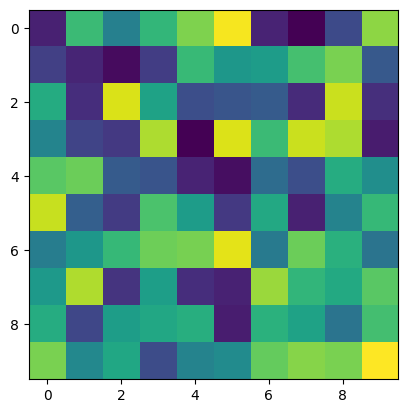

In [5]:
mlp = MLP(10, 10, 10)

# print(mlp.state_dict())

plt.imshow(mlp.state_dict()['lin1.weight'])

# training code

In [6]:
def test_eval(
    model: nn.Module,
    test_loader: DataLoader,
    test_batches: int|None = 10,
) -> dict[str, float]:
    """Evaluate the model on the test set.
    
    we want to keep track of how the model is doing on the held-out test set, so we can see if it is overfitting.
    this function helps us do that.
    """
    # keep track of the loss and accuracy
    test_hist: list[dict[str, float]] = list()

    # set the model to evaluation mode -- dont keep track of gradients!
    model.eval()

    # iterate over the batches of the dataset
    for batch_idx, (data, target) in enumerate(test_loader):
        # move things to the right device
        data, target = data.to(DEVICE), target.to(DEVICE)
        # forward pass
        output = model(data)
        # calculate the loss
        loss = nn.CrossEntropyLoss()(output, target)
        
        # keep track of the loss and accuracy
        hist_item: dict[str, float] = dict(
            test_loss=loss.item(),
            test_accuracy=(output.argmax(dim=1) == target).float().mean().item(),
        )
        test_hist.append(hist_item)

        if test_batches and batch_idx >= test_batches:
            break

    # calculate the average loss and accuracy
    avg_loss = torch.tensor([hist_item['test_loss'] for hist_item in test_hist]).mean().item()
    avg_accuracy = torch.tensor([hist_item['test_accuracy'] for hist_item in test_hist]).mean().item()

    return dict(test_loss=avg_loss, test_accuracy=avg_accuracy)



In [7]:

def hist_item_to_str(hist: dict[str, float]) -> str:
    """for printing how the model is doing during training"""
    return '\t'.join([
        'total_samples: {samples:7d}',
        'tr_L: {train_loss:6.4f}',
        'tr_A: {train_accuracy:6.4f}',
        'ts_L: {test_loss:6.4f}',
        'ts_A: {test_accuracy:6.4f}',
    ]).format(**hist)


def train(
        model: nn.Module, 
        optimizer: optim.Optimizer, 
        train_loader: DataLoader, 
        test_loader: DataLoader,
        epochs: int,
        test_batches: int|None = 10,
        test_interval: int = 100,
    ) -> None:
    # set the model to training mode
    model.train()

    # keep track of the loss and accuracy
    model.train_hist = list()

    # iterate over the dataset `epochs` number of 
    samples: int = 0
    for epoch in range(1, epochs + 1):
        # iterate over the batches of the dataset
        for batch_idx, (data, target) in enumerate(train_loader):
            samples += len(data)
            # move things to the right device
            data, target = data.to(DEVICE), target.to(DEVICE)
            # reset the gradients
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate the loss
            loss = nn.CrossEntropyLoss()(output, target)
            # backward pass, update gradient
            loss.backward()
            optimizer.step()
            
            # keep track of the loss and accuracy
            hist_item: dict[str, float] = dict(
                samples=samples,
                train_loss=loss.item(),
                train_accuracy=(output.argmax(dim=1) == target).float().mean().item(),
            )

            # evaluations are expensive, and we dont want to spam the console with progress updates
            # so we only do this once in a while
            if (samples % test_interval == 0) or batch_idx in (0, len(train_loader) - 1):
                # evaluate the model on the test set
                hist_item.update(test_eval(model, test_loader, test_batches))

                # print how the model is doing
                print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] {hist_item_to_str(hist_item)}')
            
            # save the history as an attribute of the model
            model.train_hist.append(hist_item)


In [8]:

def main_train(
    model: nn.Module,
    batch_size: int = 128,
    lr: float = 0.001,
    epochs: int = 2,
    test_batches: int|None = 10,
    test_interval: int = 100,
) -> None:
    
    # get the number of trainable parameters in the model
    num_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{num_params = }")
    model.num_params = num_params
    
    # convert dataset to "DataLoaders", which batch and shuffle the data
    train_loader = DataLoader(dataset=TRAIN_DATASET, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=TEST_DATASET, batch_size=batch_size, shuffle=False)

    # move the model to the right device
    model = model.to(DEVICE)
    # set up the optimizer, based on the parameters of the model
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # train the model
    train(
        model = model,
        optimizer = optimizer,
        train_loader = train_loader,
        test_loader = test_loader,
        epochs = epochs,
        test_batches = test_batches,
        test_interval = test_interval,
    )

    return model



In [9]:
def plot_hist(data: list[dict[str, float]]):
	# we could hardcode which keys, but this is more flexible if we want to add more evaluations later
	keys: set[str] = set(
		key
		for hist_item in data
		for key in hist_item.keys()
	)

	# we dont want to plot the samples, since that is the x-axis
	assert 'samples' in keys
	keys.remove('samples')

	# set up the figure
	fig, (ax_loss, ax_acc) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

	# plot each metric
	for key in keys:
		# note that not all keys are present in all hist_items
		# but we still want every value to be plotted at the correct sample
		x: list[float] = list()
		y: list[float] = list()
		for hist_item in data:
			if key in hist_item:
				x.append(hist_item['samples'])
				y.append(hist_item[key])

		# loss and accuracy are on different axes
		ax = ax_loss if key.endswith('loss') else ax_acc
		ax.plot(x, y, label=key)
	
	# make it look nice
	ax_loss.legend()
	ax_loss.set_ylabel('loss')
	ax_acc.set_ylabel('accuracy')
	ax_acc.legend()
	plt.show()

# train the model!

num_params = 7960
Epoch 1 [0/60000] total_samples:     128	tr_L: 2.3071	tr_A: 0.1172	ts_L: 2.2977	ts_A: 0.1200
Epoch 1 [3072/60000] total_samples:    3200	tr_L: 1.9249	tr_A: 0.4297	ts_L: 1.9594	ts_A: 0.3793
Epoch 1 [6272/60000] total_samples:    6400	tr_L: 1.6324	tr_A: 0.5781	ts_L: 1.6470	ts_A: 0.6044
Epoch 1 [9472/60000] total_samples:    9600	tr_L: 1.2796	tr_A: 0.7266	ts_L: 1.3906	ts_A: 0.6882
Epoch 1 [12672/60000] total_samples:   12800	tr_L: 1.2338	tr_A: 0.6953	ts_L: 1.1891	ts_A: 0.7280
Epoch 1 [15872/60000] total_samples:   16000	tr_L: 0.9445	tr_A: 0.7812	ts_L: 1.0442	ts_A: 0.7514
Epoch 1 [19072/60000] total_samples:   19200	tr_L: 0.8453	tr_A: 0.7656	ts_L: 0.9382	ts_A: 0.7663
Epoch 1 [22272/60000] total_samples:   22400	tr_L: 0.8945	tr_A: 0.7188	ts_L: 0.8624	ts_A: 0.7855
Epoch 1 [25472/60000] total_samples:   25600	tr_L: 0.6676	tr_A: 0.8281	ts_L: 0.8057	ts_A: 0.7912
Epoch 1 [28672/60000] total_samples:   28800	tr_L: 0.6990	tr_A: 0.8047	ts_L: 0.7577	ts_A: 0.7997
Epoch 1 [31872/6000

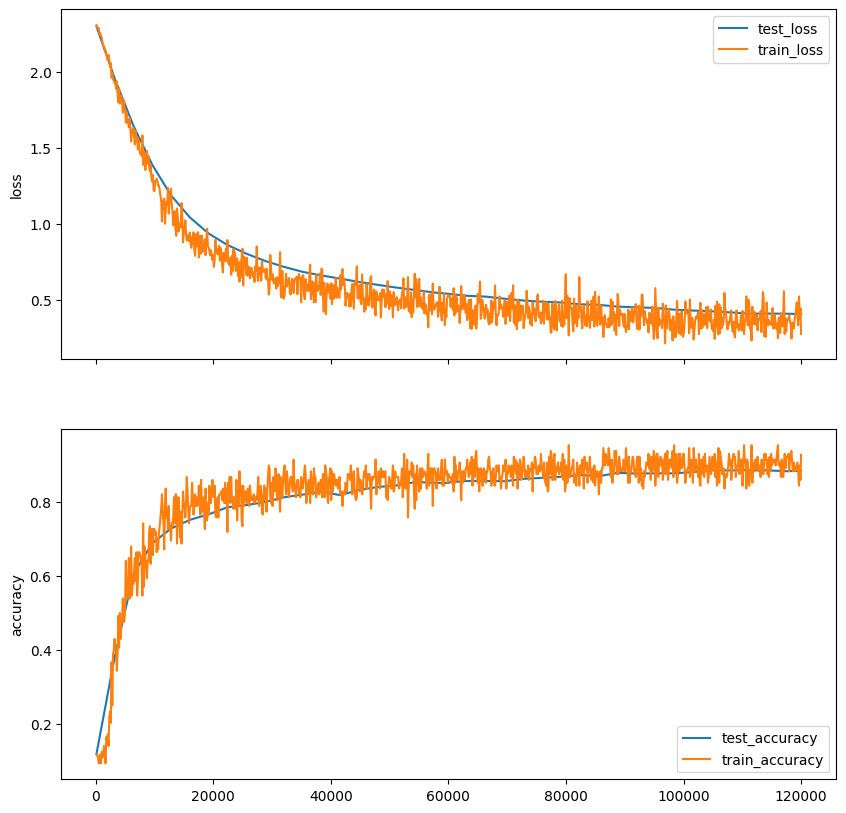

In [10]:
MODEL = main_train(
    model = MLP(
        input_size = 28 * 28,
        hidden_size = 10,
        num_classes = 10,
    ),
    batch_size = 128,
    lr = 0.001,
    epochs = 2,
    test_batches = 10,
    test_interval = 100,
)
plot_hist(MODEL.train_hist)

# what's going on inside?

vlim = 0.4547353684902191
showing 10 neurons out of 10


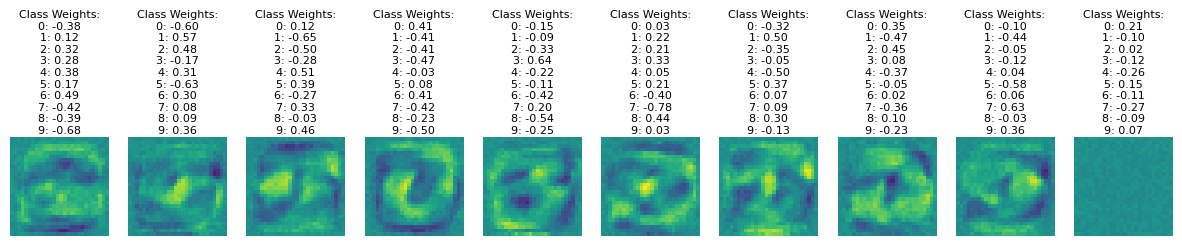

In [11]:
def plot_perceptive_fields_mlp(
		model: nn.Module,
		n_fields: int = 10,
		find_important: bool = True,
		cmap: str = 'RdBu',
	) -> None:
	fig, axes = plt.subplots(1, n_fields, figsize=(15, 15))

	# get the weights of the first layer -- how each pixel is connected to each neuron
	# .detach() makes sure we dont keep track of gradients
	# .cpu() makes sure we are on the CPU, so we can use matplotlib
	weights_1: torch.Tensor = model.lin1.weight.detach().cpu()
	weights_2: torch.Tensor = model.lin2.weight.detach().cpu()

	if find_important:
		# find the most important neurons by looking at the
		# sum of weights for that neuron in the next layer
		outputs_sum: torch.Tensor = weights_2.abs().sum(dim=0)
		# sort the neurons by importance
		_, indices = outputs_sum.sort(descending=True)
		# select the most important neurons
		weights_1 = weights_1[indices]

	# find the maximum absolute value of the weights (for color scaling)
	vlim: float = weights_1.abs().max().item()
	print(f'{vlim = }')
	print(f'showing {n_fields} neurons out of {weights_1.shape[0]}')
	for i in range(n_fields):
		axes[i].imshow(
			weights_1[i].view(28, 28), # unflatten the weights to a 28x28 image
			cmap=cmap, vmin=-vlim, vmax=vlim, # color scaling
		)
		axes[i].axis('off')

		# Extract and display the weights to each class for the current neuron
		class_weights = weights_2[:, indices[i]].numpy()
		class_weight_text = '\n'.join([f'{c}: {w:.2f}' for c, w in enumerate(class_weights)])
		axes[i].set_title(f'Class Weights:\n{class_weight_text}', fontsize=8, pad=3)
	plt.show()

plot_perceptive_fields_mlp(MODEL, cmap=None)

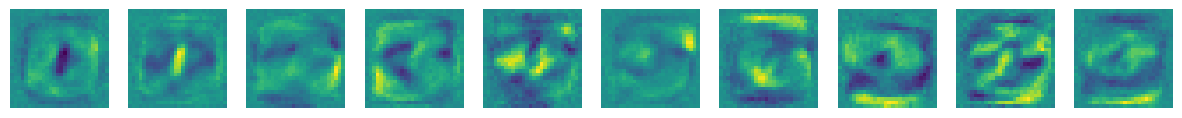

In [12]:
def plot_perceptive_fields_mlp_second_layer(
		model: nn.Module,
		n_fields: int = 10,
		cmap: str = 'RdBu',
	) -> None:
	fig, axes = plt.subplots(1, n_fields, figsize=(15, 15))

	# Extract weights from the first and second layers
	weights_first_layer: torch.Tensor = model.lin1.weight.detach().cpu()
	weights_second_layer: torch.Tensor = model.lin2.weight.detach().cpu()


	for i in range(n_fields):
		# Combine the weights of the first and second layers
		combined_weights = weights_second_layer[i] @ weights_first_layer

		# Determine the maximum absolute value for color scaling
		vlim = combined_weights.abs().max().item()

		axes[i].imshow(
		combined_weights.view(28, 28),  # unflatten the combined weights to a 28x28 image
		cmap=cmap, vmin=-vlim, vmax=vlim,  # color scaling
		)
		axes[i].axis('off')

	plt.show()

plot_perceptive_fields_mlp_second_layer(MODEL, cmap=None)

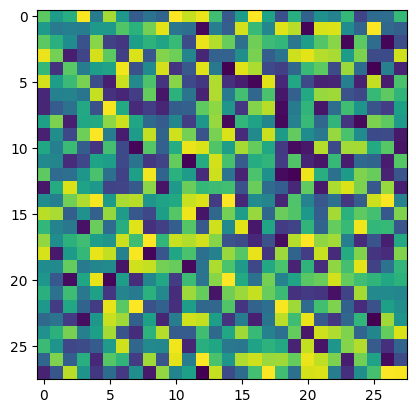

In [13]:
import numpy as np
test_img = np.random.rand(28, 28)
plt.imshow(test_img)

In [14]:
MODEL.state_dict()['lin1.weight'].shape

torch.Size([10, 784])

In [15]:
img_flat = torch.tensor([test_img]).flatten().unsqueeze(0)
img_flat.shape
MODEL.forward(img_flat.float().to(DEVICE))

/tmp/ipykernel_409182/3319180174.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img_flat = torch.tensor([test_img]).flatten().unsqueeze(0)


tensor([[-6.6464, -2.6791,  1.5578,  5.6726, -8.4357,  1.6595,  1.6342, -5.4985,
          1.5084, -8.8118]], device='cuda:0', grad_fn=<AddmmBackward0>)

tensor([[-0.8466, -5.6219, -3.7377,  2.6914, -5.3032,  1.5965, -2.1992,  0.0151,
         -1.4646, -3.7720]], device='cuda:0', grad_fn=<AddmmBackward0>)

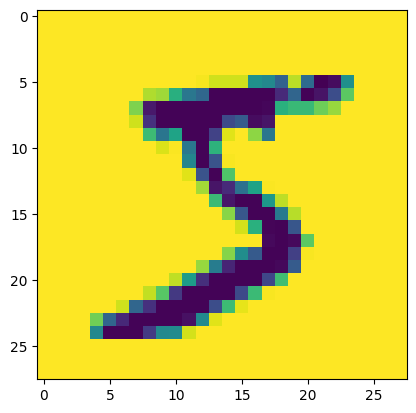

In [16]:
x = TRAIN_DATASET[0][0]
x.shape
plt.imshow(x[0])


# invert the image
x_inv = 1 - x
plt.imshow(x_inv[0])


MODEL.forward(x.flatten().unsqueeze(0).to(DEVICE))

# convolutional nets

In [17]:
def compute_kernel_output_dim(
	input_size: int,
	kernel_size: int,
	kernel_channels: int,
	stride: int,
	padding: int,
) -> int:
	return kernel_channels * (
		(input_size - kernel_size + 2 * padding + 1)
		// stride
	) ** 2

In [18]:
class ConvNet(nn.Module):
    def __init__(
            self, 
            input_shape: tuple[int, int], # (height, width) of the input image 
            kernel_size: int, # size of the convolutional kernel
            kernel_channels: int, # number of convolutional kernels (output channels)
            num_classes: int, # number of classes in the output
            stride: int = 1, # how much the kernel moves each step
            padding: int = 2, # how much padding to add to the input 
            pool_kernel_size: int = 5, # size of the pooling kernel
        ) -> None:
        super(ConvNet, self).__init__()
        self.conv = nn.Conv2d(1, kernel_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
        assert input_shape[0] == input_shape[1]
        input_size: int = input_shape[0]
        
        self.pool_output_dim: int = compute_kernel_output_dim(
            input_size=input_size,
            kernel_size=kernel_size,
            kernel_channels=kernel_channels,
            stride=stride,
            padding=padding,
        ) // pool_kernel_size ** 2

        self.lin = nn.Linear(self.pool_output_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        out = out.view(out.shape[0], -1)
        out = self.lin(out)
        return out

num_params = 3710
Epoch 1 [0/60000] total_samples:      16	tr_L: 2.4455	tr_A: 0.0000	ts_L: 2.3110	ts_A: 0.0568
Epoch 1 [384/60000] total_samples:     400	tr_L: 2.2322	tr_A: 0.1875	ts_L: 2.1925	ts_A: 0.2557
Epoch 1 [784/60000] total_samples:     800	tr_L: 2.1001	tr_A: 0.3125	ts_L: 2.0359	ts_A: 0.3807
Epoch 1 [1184/60000] total_samples:    1200	tr_L: 1.9319	tr_A: 0.4375	ts_L: 1.7900	ts_A: 0.5227
Epoch 1 [1584/60000] total_samples:    1600	tr_L: 1.4420	tr_A: 0.6875	ts_L: 1.4940	ts_A: 0.6705
Epoch 1 [1984/60000] total_samples:    2000	tr_L: 1.6769	tr_A: 0.5625	ts_L: 1.2530	ts_A: 0.7386
Epoch 1 [2384/60000] total_samples:    2400	tr_L: 1.2533	tr_A: 0.6250	ts_L: 1.0613	ts_A: 0.7841
Epoch 1 [2784/60000] total_samples:    2800	tr_L: 0.7021	tr_A: 0.8125	ts_L: 0.9703	ts_A: 0.7330
Epoch 1 [3184/60000] total_samples:    3200	tr_L: 0.9195	tr_A: 0.8125	ts_L: 0.8778	ts_A: 0.7216
Epoch 1 [3584/60000] total_samples:    3600	tr_L: 0.6366	tr_A: 0.8750	ts_L: 0.7989	ts_A: 0.7500
Epoch 1 [3984/60000] total_

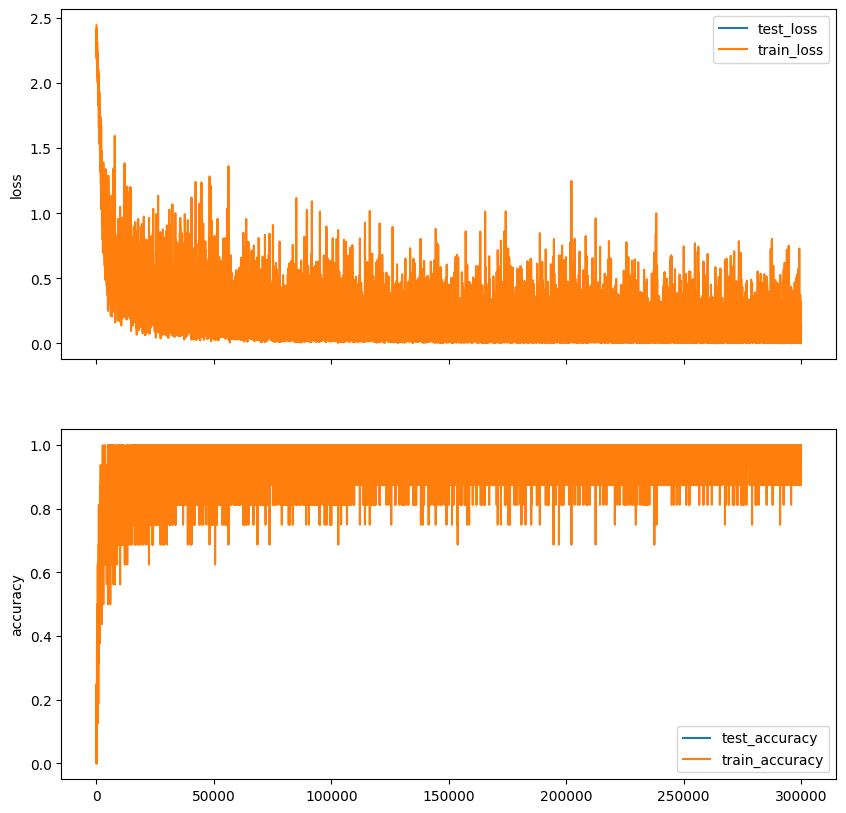

In [19]:
MODEL_CONV = main_train(
	model = ConvNet(
		input_shape = (28, 28),
		kernel_size = 3,
		kernel_channels = 10,
		num_classes = 10,
	),
	batch_size = 16,
	lr = 0.001,
	epochs = 5,
	test_batches = 10,
	test_interval = 100,
)

plot_hist(MODEL_CONV.train_hist)

# what are those kernels doing?

In [20]:
def visualize_kernels_and_effects(model, dataset, n_images=1):
    # Ensure the model is in evaluation mode
    model.eval()

    # Extract the kernels from the first convolutional layer
    kernels = model.conv.weight.data

    # Number of kernels (channels)
    n_kernels = kernels.shape[0]

    for i in range(n_images):
        # Get an image and label from the dataset
        image, _ = dataset[i]
        image_unsq = image.unsqueeze(0).to(DEVICE)  # Add batch dimension

        # Create a figure with subplots
        fig, axes = plt.subplots(3, n_kernels, figsize=(n_kernels * 3, 9))

        for idx in range(n_kernels):
            kernel = kernels[idx]

            # Plot the original image in the first row
            if idx == 0:
                axes[0, idx].imshow(image.squeeze().numpy(), cmap='gray')
                axes[0, idx].set_title('Original Image')
            axes[0, idx].axis('off')

            # Apply the kernel to the image
            with torch.no_grad():
                filtered_img = F.conv2d(image_unsq, kernel.unsqueeze(0))

            # Plot the image after applying the kernel in the second row
            axes[1, idx].imshow(filtered_img[0].squeeze().cpu().numpy(), cmap='gray')
            axes[1, idx].set_title(f'Channel {idx + 1}')
            axes[1, idx].axis('off')

            # Plot the kernel in the third row
            axes[2, idx].imshow(kernel[0].detach().cpu().numpy(), cmap='RdBu', vmin=-1, vmax=1)
            axes[2, idx].set_title(f'Kernel {idx + 1}')
            axes[2, idx].axis('off')

        plt.show()


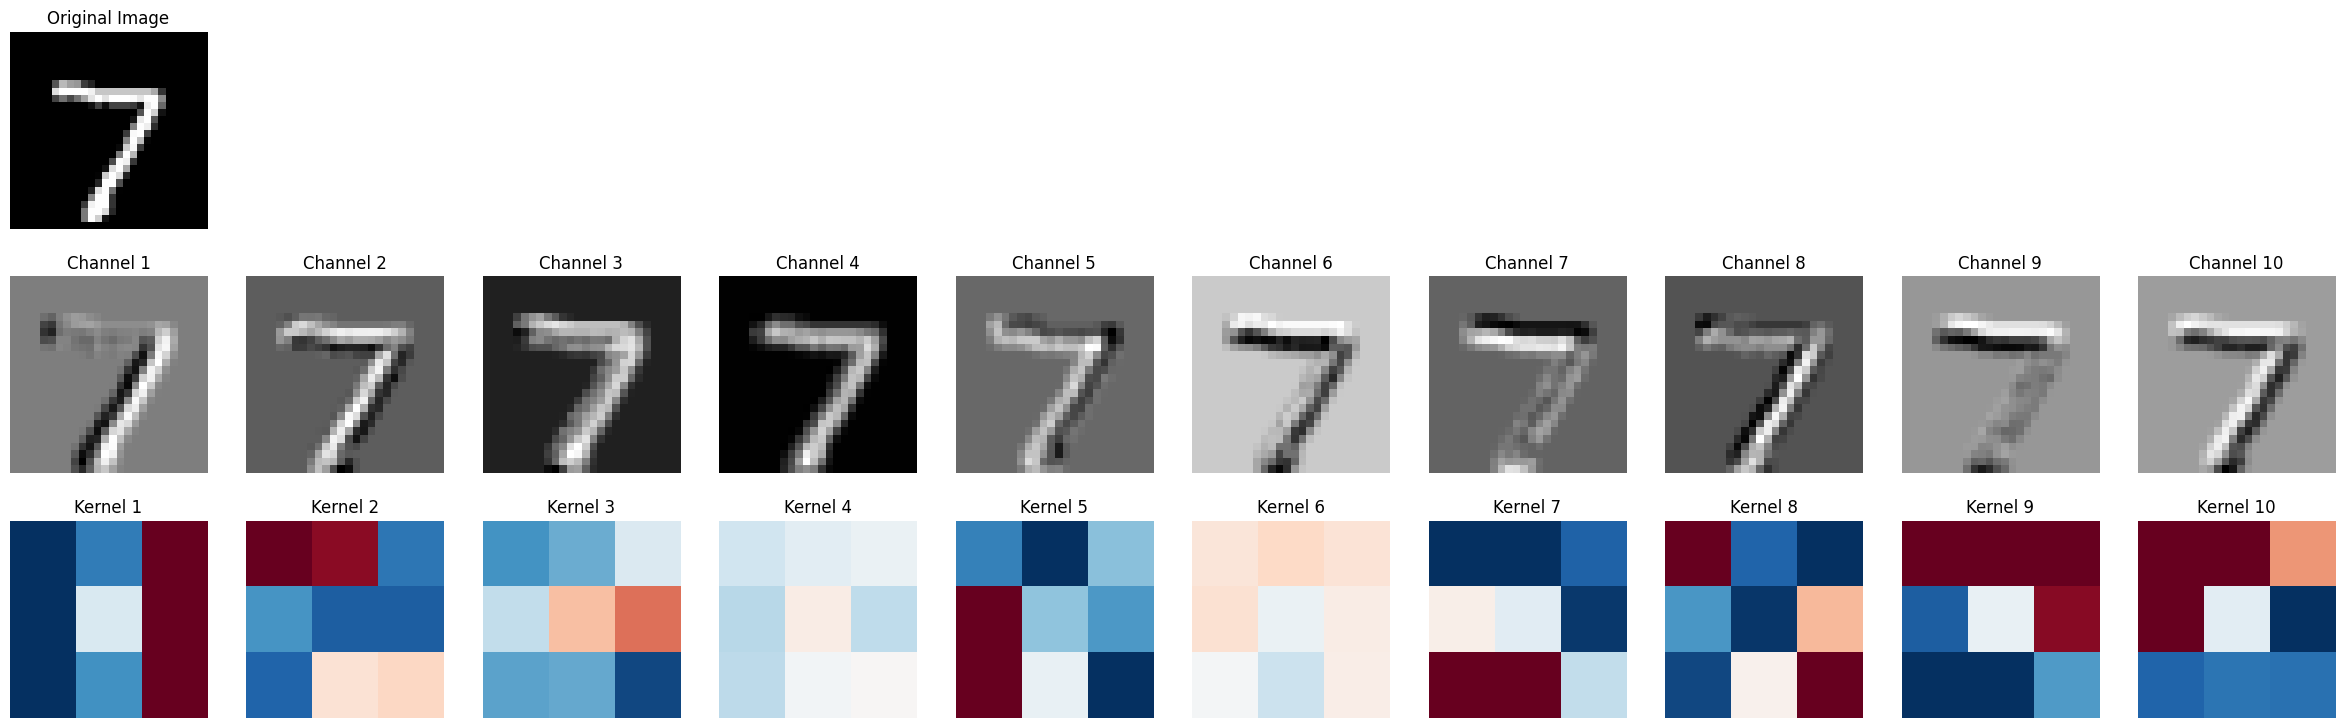

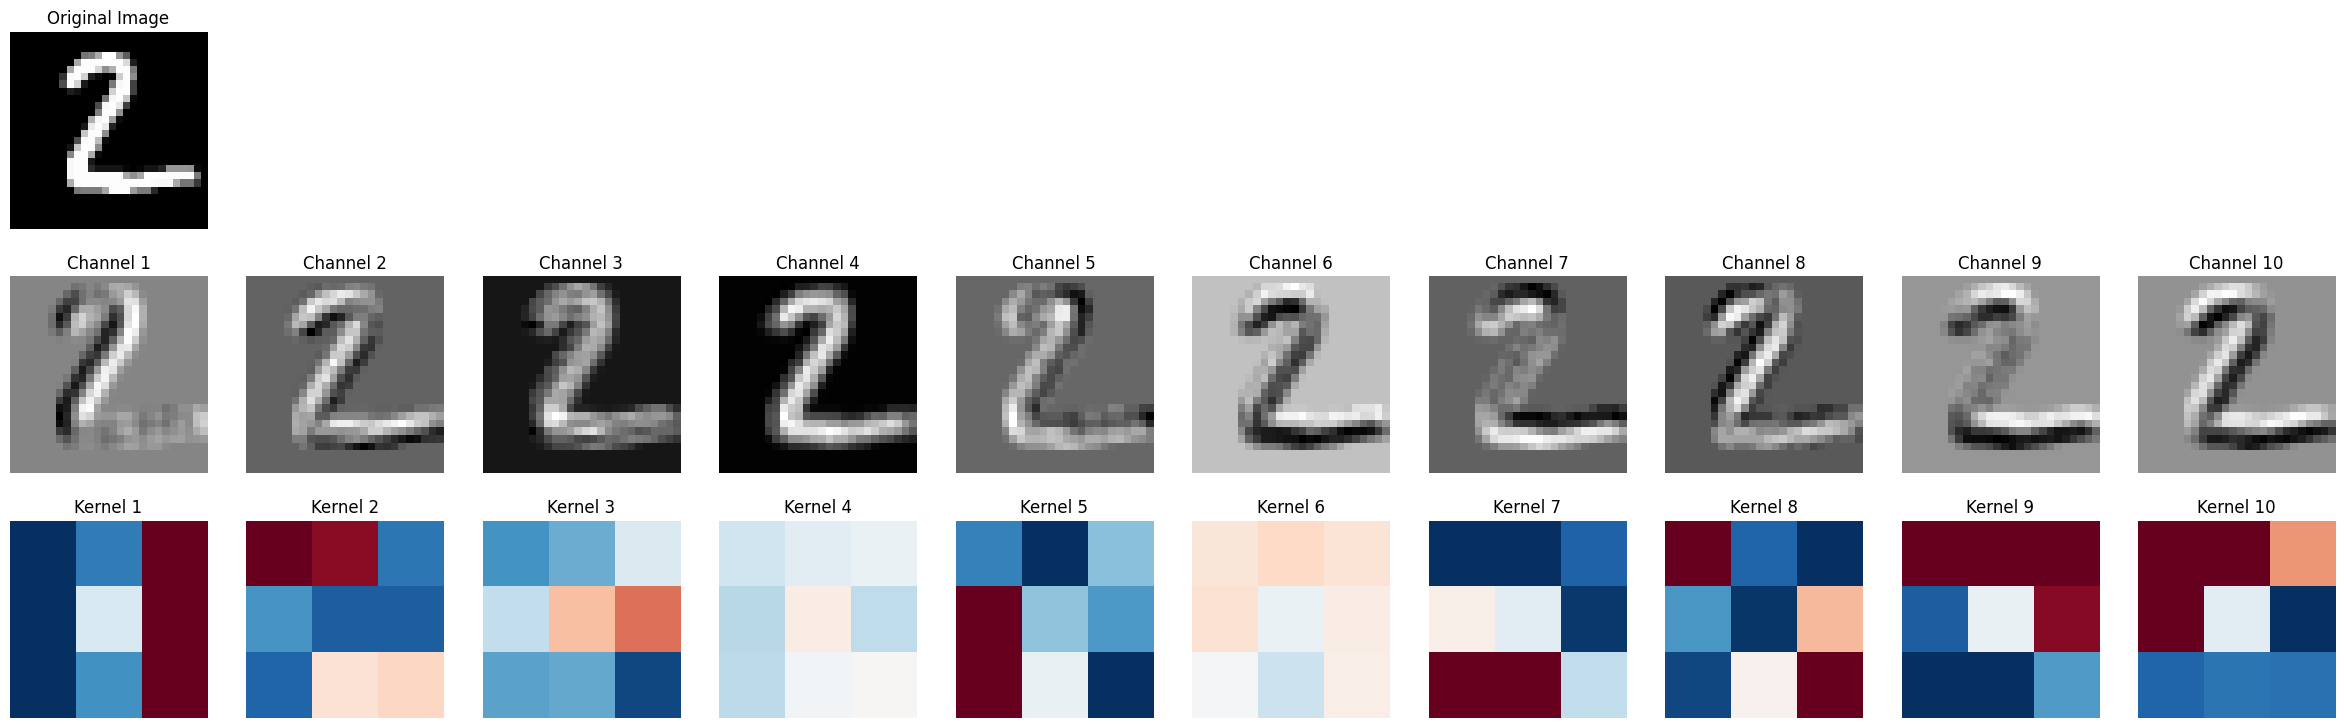

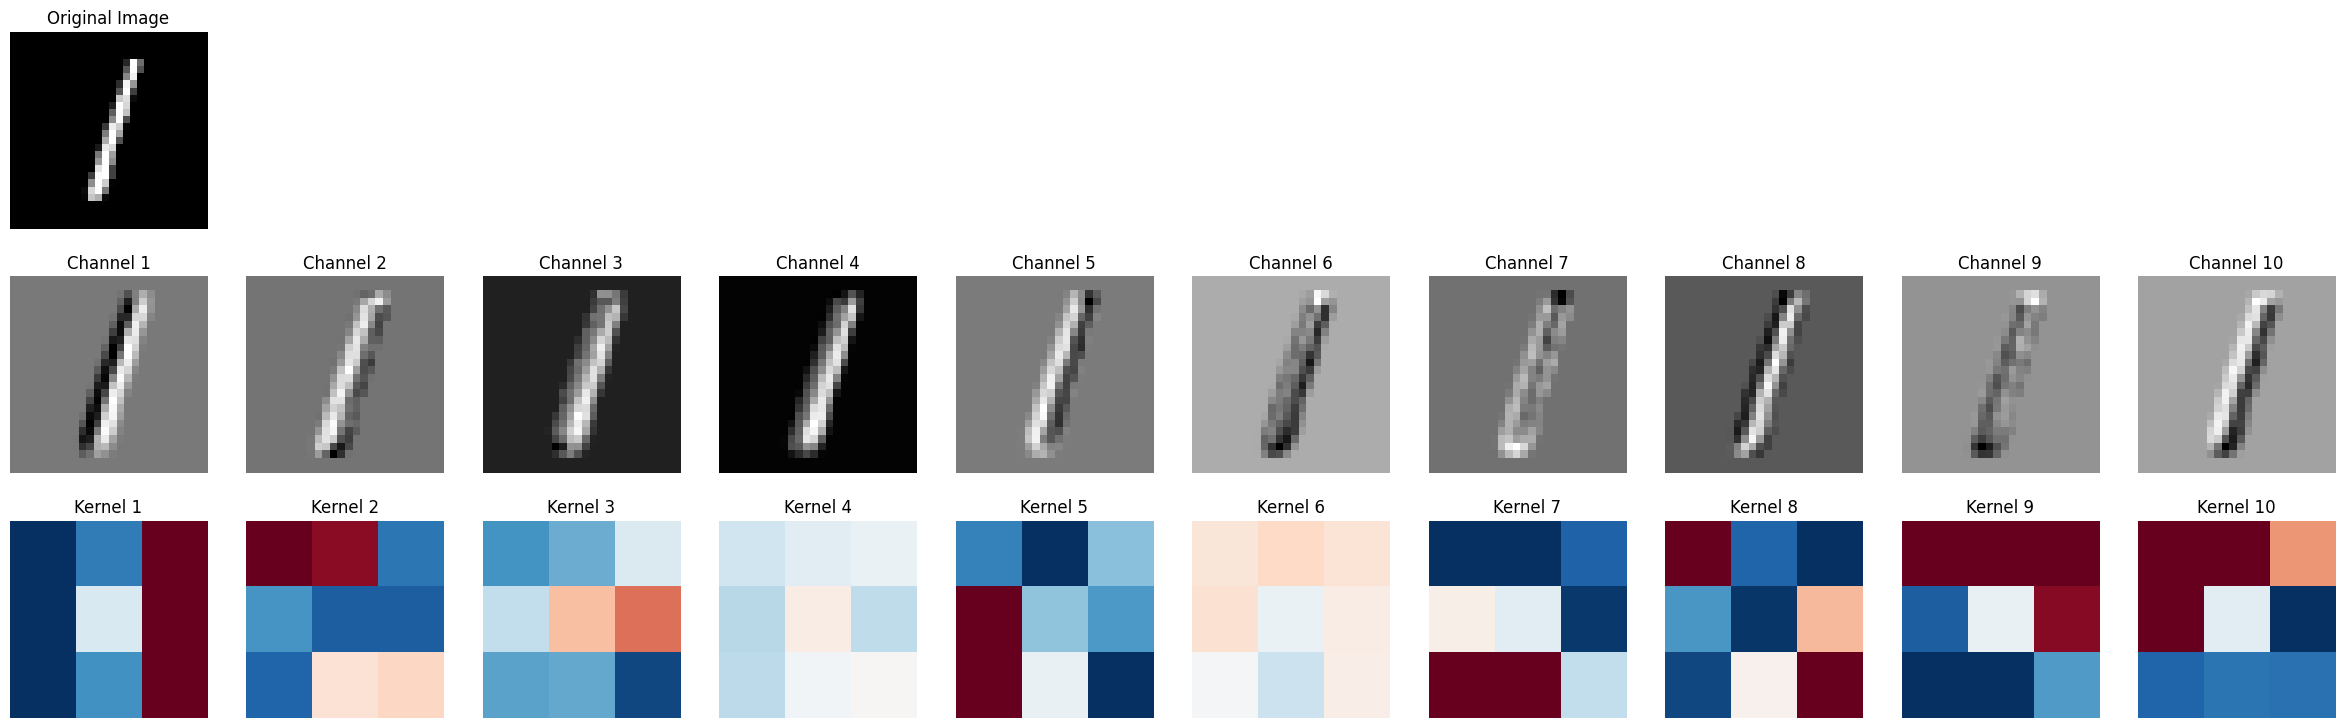

In [21]:
visualize_kernels_and_effects(MODEL_CONV, TEST_DATASET, n_images=3)

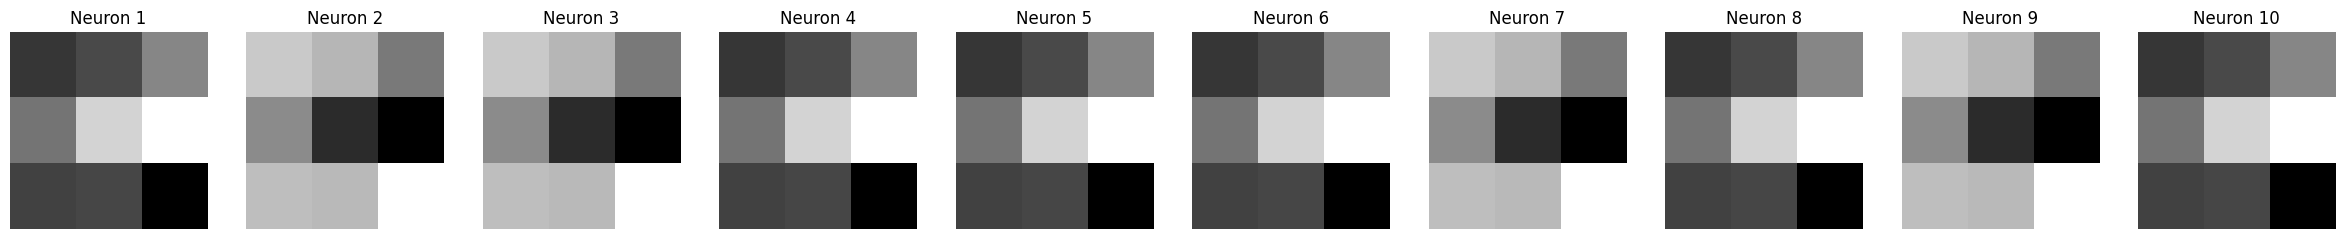

In [22]:
def visualize_second_layer_attention(model, kernel_index, dataset, n_neurons=10):
    # Ensure the model is in evaluation mode
    model.eval()

    # Extract the weights from the first convolutional layer
    kernels = model.conv.weight.data

    # Check if the kernel_index is valid
    if kernel_index >= kernels.shape[0]:
        raise ValueError(f"Kernel index {kernel_index} is out of bounds for the model's convolutional layer.")

    # Extract the weights from the second layer (assuming it's a linear layer)
    second_layer_weights = model.lin.weight.data

    # Select the specific kernel
    selected_kernel = kernels[kernel_index]

    # Number of neurons to visualize from the second layer
    n_neurons = min(n_neurons, second_layer_weights.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(1, n_neurons, figsize=(n_neurons * 3, 3))

    for i in range(n_neurons):
        # Weights from the i-th neuron in the second layer to the kernel
        neuron_weights = second_layer_weights[i, kernel_index]

        # Plot the kernel weighted by the neuron's connection strength
        weighted_kernel = selected_kernel * neuron_weights
        axes[i].imshow(weighted_kernel[0].detach().cpu().numpy(), cmap='gray')
        axes[i].set_title(f'Neuron {i + 1}')
        axes[i].axis('off')

    plt.show()

# Example usage
# model = ConvNet(...)
visualize_second_layer_attention(MODEL_CONV, kernel_index=2, dataset=TEST_DATASET, n_neurons=10)
